<a href="https://colab.research.google.com/github/anantpatil146/DeepLearning-Practical-1/blob/main/EncodeDecoderSelfAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
df = pd.read_csv('/content/Articles.csv', encoding='ISO-8859-1')

df = df[['Article', 'Heading']].dropna()

# Add [start] and [end] tokens
df['Heading'] = '[start] ' + df['Heading'] + ' [end]'

# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub('\s+', ' ', text).strip()
    return text

df['Article'] = df['Article'].apply(clean_text)
df['Heading'] = df['Heading'].apply(clean_text)


In [ ]:
news_tokenizer = Tokenizer(oov_token='<OOV>')
news_tokenizer.fit_on_texts(df['Article'])
news_seq = news_tokenizer.texts_to_sequences(df['Article'])

title_tokenizer = Tokenizer(oov_token='<OOV>')
title_tokenizer.fit_on_texts(df['Heading'])
title_seq = title_tokenizer.texts_to_sequences(df['Heading'])

max_news_len = 200
max_title_len = 30

news_pad = pad_sequences(news_seq, maxlen=max_news_len, padding='post', truncating='post')
title_pad = pad_sequences(title_seq, maxlen=max_title_len, padding='post', truncating='post')

decoder_input = title_pad[:, :-1]
decoder_target = title_pad[:, 1:]

news_vocab_size = len(news_tokenizer.word_index) + 1
title_vocab_size = len(title_tokenizer.word_index) + 1


In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, _ = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        return self.dense(concat_attention)

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        attn_output = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.layernorm3 = tf.keras.layers.LayerNormalization()

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        attn1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)

        attn2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)


In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

        return x

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
                 pe_input, pe_target, rate=0.1):
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def create_padding_mask(self, seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask

    def call(self, inputs, training=False):
        inp, tar = inputs

        enc_padding_mask = self.create_padding_mask(inp)
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(tar)[1])
        dec_padding_mask = self.create_padding_mask(inp)

        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)
        dec_output = self.decoder(tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

        return self.final_layer(dec_output)


In [ ]:
NUM_LAYERS = 4
D_MODEL = 128
NUM_HEADS = 4
DFF = 512
EPOCHS = 50
BATCH_SIZE = 32

transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=news_vocab_size,
    target_vocab_size=title_vocab_size,
    pe_input=max_news_len,
    pe_target=max_title_len
)

transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

transformer.fit(
    [news_pad, decoder_input],
    decoder_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.5890 - loss: 7.1664
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6850 - loss: 5.4590
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.6850 - loss: 4.1143
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.6833 - loss: 3.0883
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7061 - loss: 2.5438
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7188 - loss: 2.3295
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7233 - loss: 2.2213
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.7260 - loss: 2.1521
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7266 - loss: 2.1065
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7298 - loss: 2.0535
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7316 - loss: 2.0208
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy:

In [ ]:
def evaluate(news_text):
    news_text = clean_text(news_text)
    news_seq = news_tokenizer.texts_to_sequences([news_text])
    news_pad_seq = pad_sequences(news_seq, maxlen=max_news_len, padding='post')

    output = [title_tokenizer.word_index['start']]

    for i in range(max_title_len):
        decoder_input_eval = pad_sequences([output], maxlen=max_title_len-1, padding='post')
        predictions = transformer([news_pad_seq, decoder_input_eval], training=False)
        predicted_id = tf.argmax(predictions[0, i]).numpy()
        output.append(predicted_id)

        if title_tokenizer.index_word.get(predicted_id) == 'end':
            break

    result = [title_tokenizer.index_word.get(i, '') for i in output if i > 0]
    return ' '.join(result).replace('[start]', '').replace('[end]', '').strip()


In [ ]:
sample_news = df['Article'][10]
print("Original Headline:", df['Heading'][10])
print("Predicted Headline:", evaluate(sample_news))


Original Headline: start tokyo stocks open 074 percent lower end
Predicted Headline: start tokyo stocks open lower after boj under end


In [ ]:
!pip install rouge
!pip install rouge-score nltk
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

# Assuming you've already imported and cleaned your data, tokenized, and padded the sequences.

# Number of samples to evaluate
num_samples = 100

# Store the metrics for each sample
metrics_list = {'BLEU': [], 'METEOR': [], 'ROUGE-1': [], 'ROUGE-2': [], 'ROUGE-L': []}

rouge = Rouge()

# Loop over a subset of the data
for i in range(num_samples):
    # Get the article and its reference headline
    article_text = df['Article'].iloc[i]
    reference = df['Heading'].iloc[i]

    # Generate the predicted headline using the evaluate function
    predicted_headline = evaluate(article_text)

    # Tokenize the reference and predicted headline
    reference_tokens = reference.split()
    predicted_tokens = predicted_headline.split()

    # Compute BLEU score
    bleu_score = corpus_bleu([[reference_tokens]], [predicted_tokens])

    # Compute METEOR score
    meteor = meteor_score([reference_tokens], predicted_tokens)

    # Compute ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)
    # Compute ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L) safely
    try:
        if predicted_headline.strip() and reference.strip():  # Check for non-empty strings
            rouge_scores = rouge.get_scores(predicted_headline, reference)
            rouge_1 = rouge_scores[0].get('rouge-1', {}).get('f', 0.0)
            rouge_2 = rouge_scores[0].get('rouge-2', {}).get('f', 0.0)
            rouge_l = rouge_scores[0].get('rouge-l', {}).get('f', 0.0)
        else:
            rouge_1, rouge_2, rouge_l = 0.0, 0.0, 0.0
    except Exception as e:
        print(f"ROUGE computation failed at index {i}: {e}")
        rouge_1, rouge_2, rouge_l = 0.0, 0.0, 0.0


    # Store the metrics for each sample
    metrics_list['BLEU'].append(bleu_score)
    metrics_list['METEOR'].append(meteor)
    metrics_list['ROUGE-1'].append(rouge_1)
    metrics_list['ROUGE-2'].append(rouge_2)
    metrics_list['ROUGE-L'].append(rouge_l)

# Calculate average scores
avg_metrics = {metric: np.mean(scores) for metric, scores in metrics_list.items()}

# Print the average scores
for metric, avg_score in avg_metrics.items():
    print(f"Average {metric}: {avg_score:.4f}")


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Average BLEU: 0.0304
Average METEOR: 0.3527
Average ROUGE-1: 0.4528
Average ROUGE-2: 0.1524
Average ROUGE-L: 0.4422


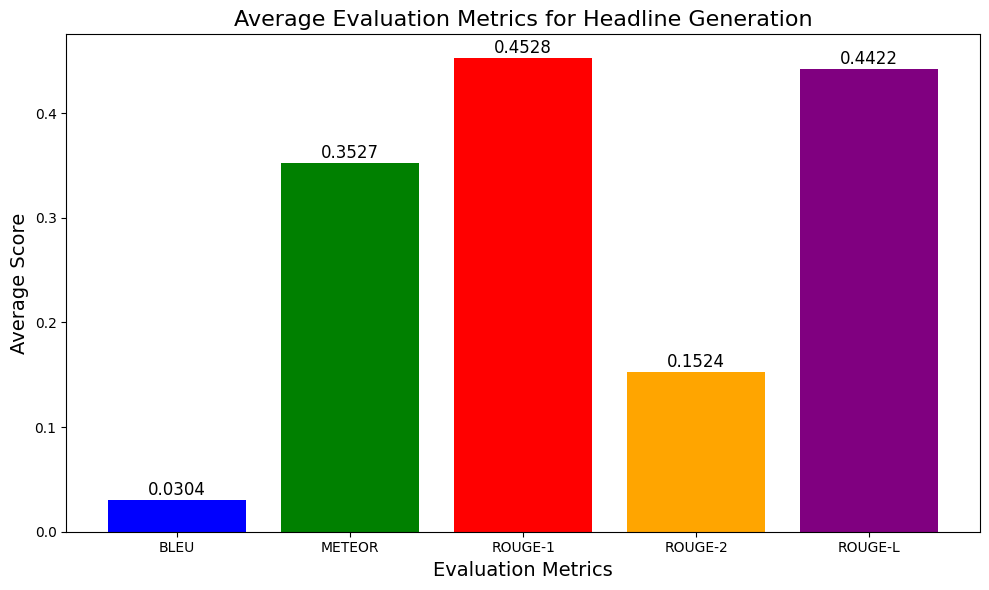

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming avg_metrics contains the average scores for each metric

# Prepare the data for plotting
metrics = list(avg_metrics.keys())
avg_scores = list(avg_metrics.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, avg_scores, color=['blue', 'green', 'red', 'orange', 'purple'])

# Add labels and title
plt.xlabel('Evaluation Metrics', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.title('Average Evaluation Metrics for Headline Generation', fontsize=16)

# Display the average scores on top of the bars
for i, score in enumerate(avg_scores):
    plt.text(i, score + 0.005, f'{score:.4f}', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
